In [16]:
# import libraries
import csv
import cv2
import os.path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Activation, Lambda, Dropout
from keras.layers import Convolution2D, Cropping2D, BatchNormalization
from keras.layers.pooling import MaxPooling2D
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# to save the trained model
MODEL_PATH  = './model.h5'
DATA_PATH   = './training/'
DATA_FILE   = './training/driving_log.csv'
IMAGE_PATH  = './training/IMG/'

ANGLE_CORRECTION  = 0.23
LEFT_RIGHT_CAMERA = True

## Build Training Data

In [6]:
def get_samples(file_name):
    """
    Get samples from csv file
    : file_name: name of the csv file 
    : return: List of samples
    """
    image_samples = []
    with open(file_name) as file:
        reader = csv.reader(file)
        for line in reader:
            
            # update image path
            line[0] = IMAGE_PATH + line[0].split('\\')[-1]
            line[1] = IMAGE_PATH + line[1].split('\\')[-1]
            line[2] = IMAGE_PATH + line[2].split('\\')[-1]
            
            image_samples.append(line)

    return image_samples


def get_train_validation_samples():
    '''
    Get the training and validation samples
    : return: tuple of training and validation samples
    '''
    samples = get_samples(DATA_FILE)
    
    train, valid = train_test_split(samples, test_size = 0.2)
    
    return (train, valid)
    
    
def flip_image(image, angle):
    """
    Flip the image and corresponding angle
    : image: image to be flipped
    : angle: current steering angle of the image
    : return: flipped image and corresponding steering angle
    """        
    image_flipped = np.fliplr(image)
    angle_flipped = -angle
            
    return (image_flipped, angle_flipped)


def get_frame_samples(sample_row):
    """
    Get sample images of current frame snapshot
    : sample_row: single row of csv sample
    : return: returns tupple of images and corresponding angles
    """
    images = []
    angles = []
    
    # centre, left and right camera images
    centre_name = sample_row[0]
    left_name   = sample_row[1]
    right_name  = sample_row[2]
    
    if os.path.exists(centre_name):
        centre_image = cv2.imread(centre_name)
        centre_angle = float(sample_row[3])
        
        images.append(centre_image)
        angles.append(centre_angle)
        
        # flip the image and corresponding camera angle
        flipped_img, flipped_angle = flip_image(centre_image, centre_angle)
        images.append(flipped_img)
        angles.append(flipped_angle)
        
    if LEFT_RIGHT_CAMERA and os.path.exists(left_name):
        left_image = cv2.imread(left_name)
        left_angle = float(sample_row[3]) + 0.23
        
        images.append(left_image)
        angles.append(left_angle)
        
        # flip the image and corresponding camera angle
        flipped_img, flipped_angle = flip_image(left_image, left_angle)
        images.append(flipped_img)
        angles.append(flipped_angle)
        
    if LEFT_RIGHT_CAMERA and os.path.exists(right_name):
        right_image = cv2.imread(right_name)
        right_angle = float(sample_row[3]) - 0.23
        
        images.append(right_image)
        angles.append(right_angle)
        
        # flip the image and corresponding camera angle
        flipped_img, flipped_angle = flip_image(right_image, right_angle)
        images.append(flipped_img)
        angles.append(flipped_angle)
    
    return (images, angles)


def get_frame_samples_count(sample_row):
    """
    Get number of images of current frame snapshot available
    : sample_row: single row of csv sample
    : return: number of sample images available from sample row
    """
    
    sample_count = 0
    
    centre_name = sample_row[0]
    left_name   = sample_row[1]
    right_name  = sample_row[2]
    
    if os.path.exists(centre_name): 
        sample_count +=2
        
    if LEFT_RIGHT_CAMERA and os.path.exists(left_name):
        sample_count +=2
        
    if LEFT_RIGHT_CAMERA and os.path.exists(right_name):
        sample_count +=2
    
    return sample_count


def get_sample_data_count(data):
    """
    Return the total samples avaialbe from given data set
    : data: complete data set
    : return: sample count
    """
    
    total_samples = 0;
           
    for i in range(0, len(data)):
        total_samples += get_frame_samples_count(data[i])
    
    return total_samples
        
    
def get_batch_data(data, batch_size=32):
    """
    Split the data into batches of given size
    : data: complete data set
    : batch_size: batch size
    """
            
    if len(data) <= batch_size: 
        batch_size = len(data)
    
    # shuffle data
    shuffle(data)
    
    while True:
        
        images = []
        angles = []
        
        for i in range(len(data)):
            
            sample_images, sample_angles = get_frame_samples(data[i])
            
            images.extend(sample_images)
            angles.extend(sample_angles)
            
            if len(images) >= batch_size: 
                
                X_train = np.array(images[ : batch_size])
                Y_train = np.array(angles[ : batch_size])
                
                yield shuffle(X_train, Y_train)
                
                if len(images) > 0:
                    images = images[(batch_size + 1) : ]
                    angles = angles[(batch_size + 1) : ]
                else:
                    images = []
                    angles = []
                    

In [7]:
x, y  = get_train_validation_samples()

print('Train samples: {}'.format(get_sample_data_count(x)))
print('Validation samples: {}'.format(get_sample_data_count(y)))

Train samples: 94290
Validation samples: 23574


## Build Neural Network

In [8]:
def add_convolution(model, layer, kernal, pool_kernal, pool_strides, padding = 'valid'):
    """
    Add convolutional layer to the model
    """
    model.add(Convolution2D(layer, kernal[0], kernal[1], border_mode = padding))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = pool_kernal, strides = pool_strides))
    

In [9]:
def build_model():
    """
    Build the neural network model
    : return: sequential model
    """
    dropout       = 0.5
    input_shape   = (160, 320, 3)
    
    conv_layers   = [16, 32, 64]
    conv_ksize    = (4, 4)
    conv_strides  = (1,1)
    pool_kernal   = (2, 2)
    pool_strides  = (2, 2)
                
    model = Sequential()
        
    # add normalization
    model.add(Lambda(lambda x: ((x - 127.) / 128.), input_shape= input_shape))
    model.add(Cropping2D(cropping = ((67,25), (0,0))))
    
    # layer-1: convolution 
    add_convolution(model, conv_layers[0], conv_ksize, pool_kernal, pool_strides)
    
    # layer-2: convolution 
    add_convolution(model, conv_layers[1], conv_ksize, pool_kernal, pool_strides)
    
    # layer-3: convolution
    add_convolution(model, conv_layers[2], conv_ksize, pool_kernal, pool_strides, padding = 'same')
    
    # flatten tensor to convert to fully connected layers
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    # Fully connected layer
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    # Fully connected layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    # output layer
    model.add(Dense(1))
    
    # compile model for mse error and adam optimizer
    model.compile(loss='mse', optimizer='adam')
    
    return model

## Train model

In [10]:
def train_model(model, train_params, show_stats = 1):
    """
    Train the neural network model and save to MODEL_PATH directory
    : return: history object of the trained model
    """        
    train, valid = get_train_validation_samples()
    
    n_train    = get_sample_data_count(train)
    n_valid    = get_sample_data_count(valid)
    epochs     = train_params['epochs']
    batch_size = train_params['batch_size']
    
    n_train = int(n_train / batch_size) * batch_size
    n_valid = int(n_valid / batch_size) * batch_size
    
    print('Training network. Training Samples: {}, Validation Samples: {}, Batch: {}'.format(n_train, n_valid, batch_size))
    
    gen_train = get_batch_data(train, batch_size= batch_size)
    gen_valid = get_batch_data(valid, batch_size = batch_size)
            
    history = model.fit_generator(generator = gen_train, samples_per_epoch= n_train, 
                                  validation_data = gen_valid, nb_val_samples = n_valid,
                                  nb_epoch = epochs, verbose = show_stats)
            
    return history

In [9]:
def  print_stats(history_object):
    """
    Print model training stats
    : history_object: history object return by model.fit_generator
    """
    
    print(history_object.history.keys())
    
    # show training stats
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('Model MSE Loss')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper right')
    
    plt.show()

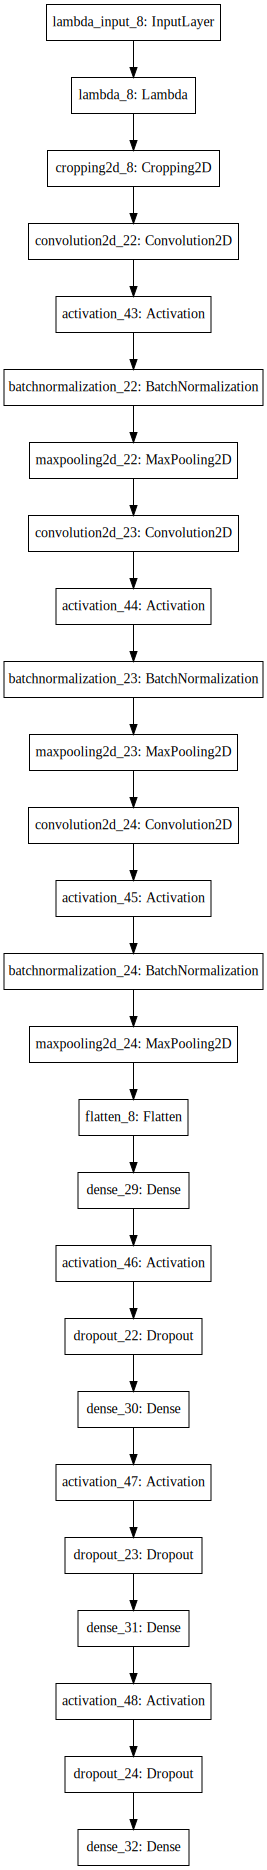

In [22]:
# train network

train_params = dict()
train_params['epochs']        = 3
train_params['batch_size']    = 64

model = build_model()

# show model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
train_hist = train_model(model, train_params, show_stats = 1)

Training network. Training Samples: 94272, Validation Samples: 23552, Batch: 64
Epoch 1/3
94272/94272 [==============================] - 189s - loss: 2.0614 - val_loss: 0.0479
Epoch 2/3
94272/94272 [==============================] - 189s - loss: 0.0532 - val_loss: 0.0408
Epoch 3/3
94272/94272 [==============================] - 190s - loss: 0.0479 - val_loss: 0.0413


dict_keys(['loss', 'val_loss'])


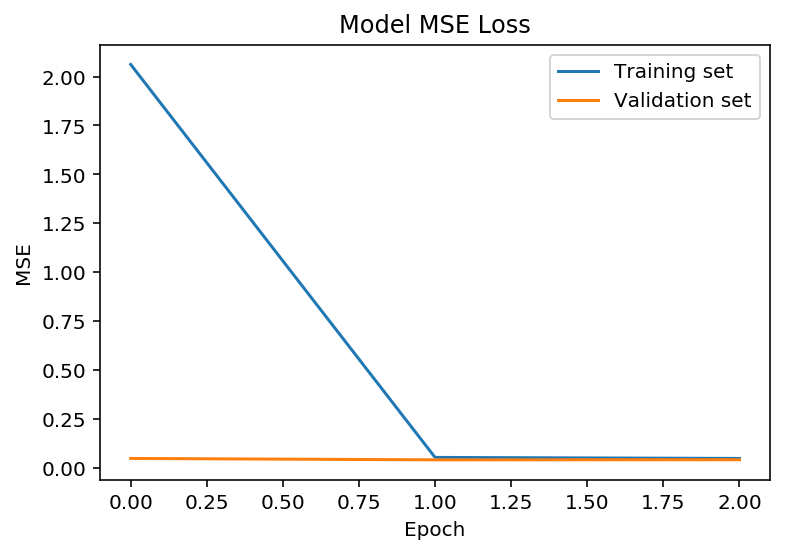

In [12]:
print_stats(train_hist)

In [13]:
# save model to the disk 
model.save(MODEL_PATH)